In [1]:
import pandas as pd
import numpy as np
import re
import string
import ssl

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2026-02-07 14:24:03.402965: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-07 14:24:03.437547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-07 14:24:03.437603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-07 14:24:03.438469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-07 14:24:03.444257: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-07 14:24:03.445181: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to /home/ana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ana/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
token = RegexpTokenizer(r"[a-zA-Z0-9]+")

In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))

    tokens = token.tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in STOPWORDS]

    return " ".join(tokens)

In [5]:
data = pd.read_csv("data/IMDB Dataset.csv")

data["target"] = data["sentiment"].apply(lambda x: 1 if x == "positive" else 0)
data["cleaned_review"] = data["review"].apply(clean_text)

data = data.drop_duplicates()
data = data[["cleaned_review", "target"]]

data.head()

,cleaned_review,target
0,one reviewer mentioned watching oz episode you...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically there family little boy jake think t...,0
4,petter matteis love time money visually stunni...,1


In [6]:
X_text = data["cleaned_review"].values
y = data["target"].values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_train_text, y_train, test_size=0.1, random_state=42, stratify=y_train
)

In [7]:
MAX_VOCAB = 20000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_text),
                        maxlen=MAX_LEN, padding="post", truncating="post")
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val_text),
                      maxlen=MAX_LEN, padding="post", truncating="post")
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test_text),
                       maxlen=MAX_LEN, padding="post", truncating="post")

vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)

In [8]:
class MyLSTM(layers.Layer):
    def __init__(self, units, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences

    def build(self, input_shape):
        input_dim = int(input_shape[-1])

        # Forget gate
        self.Wf = self.add_weight(name="Wf", shape=(input_dim, self.units), initializer="glorot_uniform")
        self.Uf = self.add_weight(name="Uf", shape=(self.units, self.units), initializer="orthogonal")
        self.bf = self.add_weight(name="bf", shape=(self.units,), initializer="zeros")

        # Input gate
        self.Wi = self.add_weight(name="Wi", shape=(input_dim, self.units), initializer="glorot_uniform")
        self.Ui = self.add_weight(name="Ui", shape=(self.units, self.units), initializer="orthogonal")
        self.bi = self.add_weight(name="bi", shape=(self.units,), initializer="zeros")

        # Candidate state
        self.Wc = self.add_weight(name="Wc", shape=(input_dim, self.units), initializer="glorot_uniform")
        self.Uc = self.add_weight(name="Uc", shape=(self.units, self.units), initializer="orthogonal")
        self.bc = self.add_weight(name="bc", shape=(self.units,), initializer="zeros")

        # Output gate
        self.Wo = self.add_weight(name="Wo", shape=(input_dim, self.units), initializer="glorot_uniform")
        self.Uo = self.add_weight(name="Uo", shape=(self.units, self.units), initializer="orthogonal")
        self.bo = self.add_weight(name="bo", shape=(self.units,), initializer="zeros")

        super().build(input_shape)

    def call(self, inputs, mask=None):
        B = tf.shape(inputs)[0]
        h = tf.zeros((B, self.units))
        c = tf.zeros((B, self.units))

        x_time = tf.transpose(inputs, perm=[1, 0, 2])
        if mask is not None:
            m_time = tf.cast(tf.transpose(mask, perm=[1, 0]), inputs.dtype)

        outputs = []

        for t in range(x_time.shape[0]):
            x_t = x_time[t]

            h_prev = h
            c_prev = c

            f = tf.sigmoid(tf.matmul(x_t, self.Wf) + tf.matmul(h, self.Uf) + self.bf)
            i = tf.sigmoid(tf.matmul(x_t, self.Wi) + tf.matmul(h, self.Ui) + self.bi)
            c_tilde = tf.tanh(tf.matmul(x_t, self.Wc) + tf.matmul(h, self.Uc) + self.bc)
            c = f * c + i * c_tilde
            o = tf.sigmoid(tf.matmul(x_t, self.Wo) + tf.matmul(h, self.Uo) + self.bo)
            h = o * tf.tanh(c)

            if mask is not None:
                m_t = tf.expand_dims(m_time[t], axis=-1)
                h = m_t * h + (1 - m_t) * h_prev
                c = m_t * c + (1 - m_t) * c_prev


            outputs.append(h)

        outputs = tf.stack(outputs)

        if self.return_sequences:
            return tf.transpose(outputs, perm=[1, 0, 2])
        else:
            return outputs[-1] 


In [9]:
inp = layers.Input(shape=(MAX_LEN,), dtype=tf.int32)

x = layers.Embedding(vocab_size, 128, mask_zero=True)(inp)
x = MyLSTM(128, return_sequences=False)(x)
x = Dropout(0.4)(x)
out = Dense(1, activation="sigmoid")(x)

my_lstm_model = Model(inp, out)
my_lstm_model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(0.001),
    metrics=["accuracy"]
)

my_lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 my_lstm (MyLSTM)            (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2691713 (10.27 MB)
Trainable params: 2691713 (10.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
early = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

history_my_lstm = my_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early],
    verbose=1
)

Epoch 1/10
558/558 [==============================] - 281s 415ms/step - loss: 0.3746 - accuracy: 0.8377 - val_loss: 0.3103 - val_accuracy: 0.8765
Epoch 2/10
558/558 [==============================] - 231s 415ms/step - loss: 0.2139 - accuracy: 0.9206 - val_loss: 0.3352 - val_accuracy: 0.8745
Epoch 3/10
558/558 [==============================] - 216s 386ms/step - loss: 0.1492 - accuracy: 0.9460 - val_loss: 0.3606 - val_accuracy: 0.8674


In [11]:
y_pred_prob = my_lstm_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"MyLSTM Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

310/310 [==============================] - 17s 29ms/step
MyLSTM Accuracy: 88.03%

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      4940
           1       0.89      0.87      0.88      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



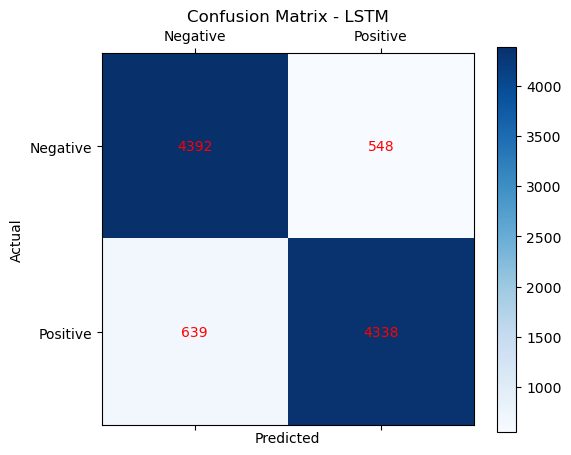

In [12]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6,5))
cax = ax.matshow(cm, cmap=plt.cm.Blues)  
plt.title('Confusion Matrix - LSTM')
fig.colorbar(cax)

ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i,j]), va='center', ha='center', color='red')

plt.show()


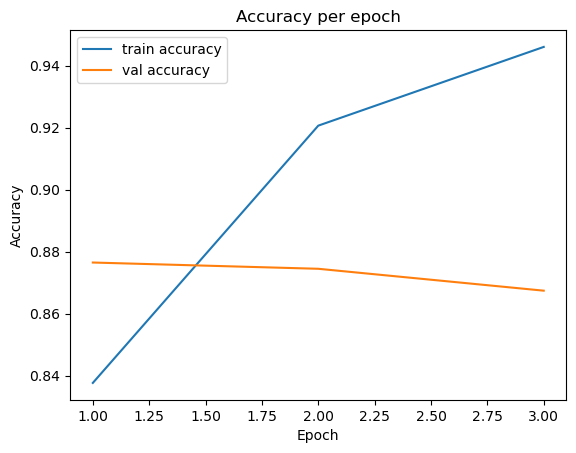

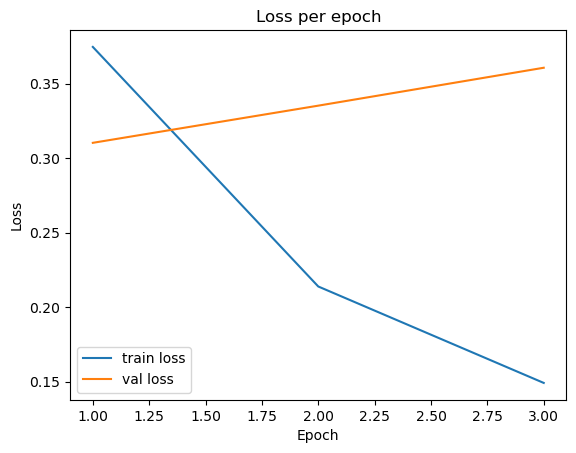

In [13]:
def plot_history(hist):
    acc = hist.history.get('accuracy', [])
    val_acc = hist.history.get('val_accuracy', [])
    loss = hist.history.get('loss', [])
    val_loss = hist.history.get('val_loss', [])

    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='train accuracy')
    plt.plot(epochs, val_acc, label='val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per epoch')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, loss, label='train loss')
    plt.plot(epochs, val_loss, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per epoch')
    plt.legend()
    plt.show()

plot_history(history_my_lstm)


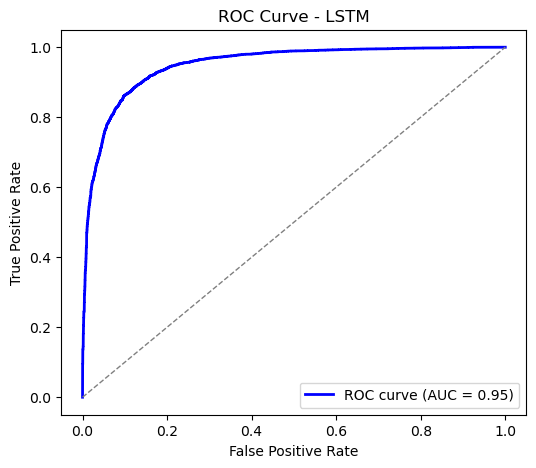

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend(loc='lower right')
plt.show()